In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rrc import rrc
from qpskdetect import qpskdetect
from qfunction import Q
import yaml

with open("siso_mimo_config.yml","r") as f:
    data = yaml.safe_load(f)

EsN0dB      = np.array(data['EsN0dB'])
EbN0dB      = np.array(data['EbN0dB'])
N0          = 10**(-EsN0dB/10)
EsN0dB_fine = np.array(data['EsN0dB_fine'])
EbN0dB_fine = np.array(data['EbN0dB_fine'])
N0_fine     = 10**(-EsN0dB_fine/10)
Es          = data['symbol_energy']
Rs          = data['symbol_rate']
Fs          = data['sampling_rate']
sps         = int(Fs/Rs)


Impulse reponse of root-raised_cosine (RRC) filter

/var/folders/7z/k5v98r4d2zv0rr3pd_k1qr040000gn/T/ipykernel_17792/2392880801.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


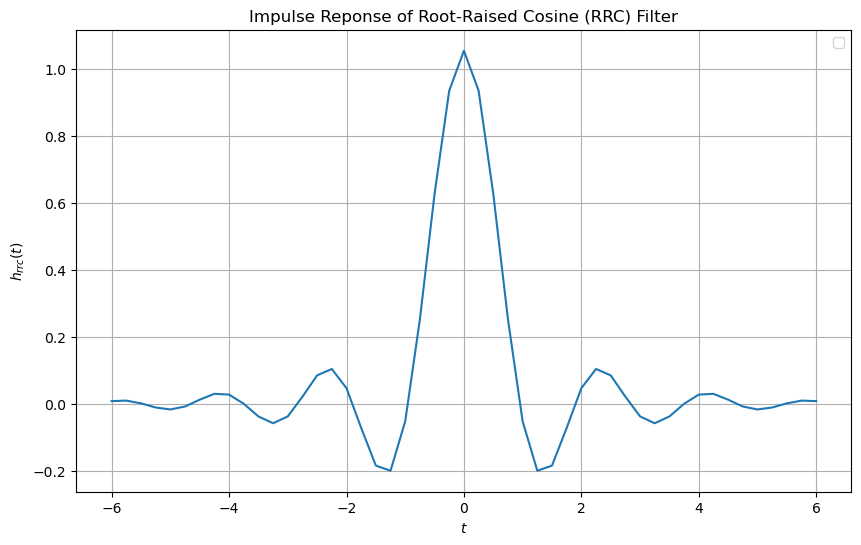

In [4]:
alpha = 0.2      # roll-off factor
T     = 1/Rs     # symbol period
t     = np.arange(-6,6+1/sps,1/sps)
hrrc  = rrc(t,alpha,T)


plt.figure(figsize=(10, 6))
plt.plot(t, hrrc)
plt.title('Impulse Reponse of Root-Raised Cosine (RRC) Filter')
plt.xlabel(r'$t$')
plt.ylabel(r'$h_{rrc}(t)$')
plt.grid(True)
plt.legend()
plt.show()

<SISO Communication Systems using QPSK Modulation>
1. AWGN Channel - Sample Level
Now, we are passing our QPSK-modulated waveform through a root-raised-cosine (RRC) pulse shaping filter and then through an additive white Gaussian noise (AWGN) channel. We are sampling the signal over a range of SNR values from -3 dB to 7 dB.
Our goal is to compare the BER obtained from demodulation with theoretical BER of QPSK Gray mapping modulation.

/var/folders/7z/k5v98r4d2zv0rr3pd_k1qr040000gn/T/ipykernel_17792/340840331.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


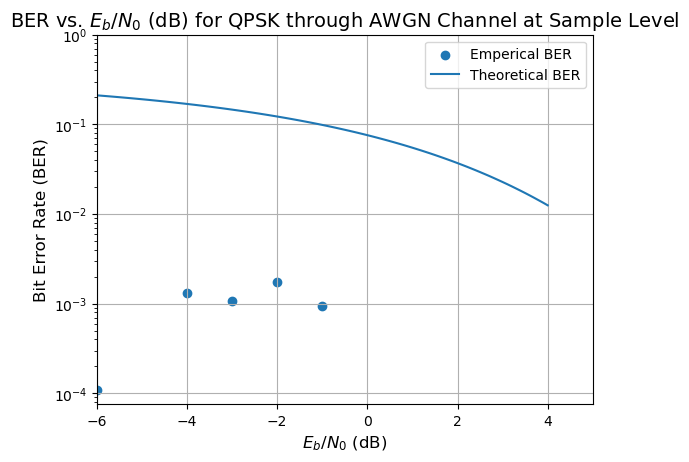

In [8]:
Nbits = int(1e6)
bitvec = np.random.randint(0,2,size=(Nbits))

symvec = ((2*bitvec[0::2]-1) + 1j*(2*bitvec[1::2]-1))/np.sqrt(2)
upsampled_symvec = np.zeros(len(symvec)*sps,dtype=complex)
upsampled_symvec[::sps] = symvec
txvec = np.convolve(upsampled_symvec,hrrc,mode='same')

ber1 = np.zeros(len(EsN0dB))
for i in range(len(EsN0dB)):
    sig2 = N0[i]*Fs/2
    noisevec = np.sqrt(sig2)*(np.random.randn(*txvec.shape) + 1j*np.random.randn(*txvec.shape))
    rxvec = txvec + noisevec
    matched_filtered_rxvec = np.convolve(rxvec,hrrc,mode='same')
    downsampled_rxvec = matched_filtered_rxvec[::sps]

    decoded_symbols, decoded_bits = qpskdetect(downsampled_rxvec)
    ber1[i] = np.sum(np.bitwise_xor(bitvec,decoded_bits))/Nbits

# Theoretical BER for Gray-Mapping QPSK
ber1_th = Q(np.sqrt(Es/N0_fine))*(1-0.5*Q(np.sqrt(Es/N0_fine)))

plt.figure(1)
plt.scatter(EbN0dB,ber1,label='Emperical BER')
plt.plot(EbN0dB_fine,ber1_th,label='Theoretical BER')
plt.yscale('log')
plt.xlim([-6, 5])
plt.ylim([0, 1])
plt.grid(True)

plt.xlabel(r'$E_b/N_0 \ (\text{dB})$', fontsize=12)
plt.ylabel('Bit Error Rate (BER)', fontsize=12)
plt.title('BER vs. $E_b/N_0$ (dB) for QPSK through AWGN Channel at Sample Level', fontsize=14)

plt.legend()
plt.show()

In [9]:
print(ber1)

[ 0.00011  -0.002034  0.001318  0.001064  0.001758  0.000945 -0.000806
 -0.001795 -0.004998 -0.013082 -0.02262 ]
